In [3]:
import torch

x=torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [4]:
x.requires_grad_(True)#设置把梯度存在何处
x.grad#用来访问梯度，默认值为None
y=2*torch.dot(x,x)#内积，即<x,x>
y

tensor(28., grad_fn=<MulBackward0>)

In [5]:
y.backward()#后向计算梯度
x.grad

tensor([ 0.,  4.,  8., 12.])

In [6]:
x.grad==4*x

tensor([True, True, True, True])

In [7]:
#默认情况下，Ptorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y=x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [18]:
#对非标量掉用‘backward’需要传入一个‘graddient’参数，该参数指定微分函数
x.grad.zero_()
y=x*x
#y
#y.sum()
#等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad


tensor([0., 2., 4., 6.])

In [19]:
x.grad.zero_()
y=x*x
u=y.detach()#把y当作一个常数而不是u的函数
z=u*x#则u就是一个常数
z.sum().backward()
x.grad==u

tensor([True, True, True, True])

features: tensor([-1.9620, -0.6315]) 
label: tensor([2.4323])


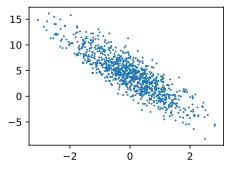

In [49]:
%matplotlib inline
import random 
import torch
from d2l import torch as d2l
#根据带有噪声的线性模型构造一个人造数据集
def synthetic_data(w,b,num_examples):
    """生成y=Xw+b+噪声。"""
    X=torch.normal(0,1,(num_examples,len(w)))#正态分布,均值为0,方差为1
    y=torch.matmul(X ,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))#把y做成一个列向量返回
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)
print('features:',features[0],'\nlabel:',labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);
#数据需要detach一下才能转到numpy中

In [86]:
#定义初始化模型参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2
#定义优化算法
def sgd(params,lr,batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():#不要计算梯度
        for param in params:
            param-= lr*param.grad/batch_size
            param.grad.zero_()
#定义一个函数，接受批量大小、特征矩阵和标签向量生成大小为batch_sizede x小批量
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    #随机读取样本，没有特定顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(
            indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]


lr=0.3
num_epochs=3#扫描次数
net=linreg
loss=squared_loss
batch_size=10
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)#x和y的小批量损失
        l.sum().backward()
        sgd([w,b],lr,batch_size)#使用参数梯度更新
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
    print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.000053
epoch2,loss0.000050
epoch3,loss0.000052


In [68]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-0.7020, -1.2968],
         [ 1.1150, -1.1718],
         [-0.6198,  0.3107],
         [ 0.3896,  0.9795],
         [-0.4765, -0.5349],
         [-0.2738,  0.3493],
         [ 1.3980,  2.5759],
         [ 0.4774, -0.2403],
         [-2.6498, -0.4696],
         [-0.4839,  0.0648]]),
 tensor([[ 7.2028],
         [10.4152],
         [ 1.9124],
         [ 1.6503],
         [ 5.0763],
         [ 2.4663],
         [-1.7700],
         [ 5.9747],
         [ 0.5003],
         [ 3.0196]])]

In [74]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')
    w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000299
epoch 2, loss 0.000099
epoch 3, loss 0.000099
w的估计误差： tensor([-0.0001, -0.0007])
b的估计误差： tensor([-0.0004])
